## Theory

Suppose that a group of $P$ students is given a test with $I$ multiple choice questions. Let $Y_{pi}=1$ mean that student $p \in \{1, ..., P\}$ has the correct answer on item $i \in \{1, ..., I\}$. Assuming that all responses are conditionally independent given the parameters $a, b, \theta$, we model the outcomes with:

$$Y_{pi} | a,b,\theta \sim Ber(\frac{e^{a_i\theta_p - b_i}}{1 + e^{a_i\theta_p - b_i}})$$

where $\theta_p$ measures the student's learning ability, $a_i$ measures the items discriminatory power, and $b_i$ measures the item's difficulty. Take the following prior assumptions on the distribution of parameters $\theta, a, b$, where all the priors are assumed independent: $a_i \sim \mathcal{N}(0, \sigma_a^2), b_i \sim \mathcal{N}(0, \sigma_b^2), \theta_p \sim \mathcal{N}(0,1)$. Then the posterior distribution of $(a, b, \theta)$ is given by

$$\pi(a,b,\theta | y) = exp\bigr\{ -\frac{1}{2\sigmasq_a^2}||a||^2 - \frac{1}{2\sigmasq_b^2}||b||^2 - \frac{1}{2}||\theta||^2 + \sum_{p,i} y_{pi}(a_i\theta_p - b_i) - log(1 + e^{a_i\theta_p - b_i}) \bigl\}$$

and the full conditionals (the conditional distribution of one variable given all others) are given by

$$\pi(a_i | b,\theta,y) = exp\bigl\{ -\frac{a_i^2}{2\sigma_a^2} + \sum_{p=1}^P a_i y_{pi} \theta_p - log(1+e^{a_i\theta_p - b_i}) \bigr\}$$


$$\pi(b_i | a, \theta, y) = exp\bigl\{ -\frac{b_i^2}{2\sigma_b^2} + \sum_{p=1}^P y_{pi}b_i - log(1+e^{a_i\theta_p - b_i}) \bigr \}$$

$$\pi(\theta_p | a, b, y) = exp\bigl\{ -\frac{\theta_p^2}{2} + \sum_{i=1}^I a_iy_{pi}\theta_p - log(1+e^{a_i\theta_p - b_i}) \bigr\}$$

Since these full conditionals are not easy to sample from, below is an implementation of the Metropolis-within-Gibbs sampler to make sampling easier.

## Implementation: classical Metropolis-within-Gibbs

In [1]:
import torch
import matplotlib.pyplot as plt
from tqdm import trange

In [2]:
def loga_conditional(a, b, theta, y, sigmasq):
    """Function to compute the (log) full conditional probability of an observed value of 
    variable a at a given index i. To get the actual conditional probability, raise
    Euler's constant to the power of the returned value.
    
    Parameters
    ----------
    a : torch.tensor
        The observed value of a at index i
    b : torch.tensor
        The observed value of b at index i
    theta : torch.tensor
        A vector of observed theta values
    y : torch.tensor
        The ith column vector of the data Y
    sigmasq : float
        The variance of variable a
        
    Returns
    -------
    prob : torch.tensor
        The (log) conditional probability
    """
    
    assert theta.shape[0] == y.shape[0]
    
    logsum = 0
    for p in range(y.shape[0]):
        logsum += a * y[p] * theta[p] - torch.log(1 + torch.exp(a*theta[p]-b))
    
    prob = logsum - (torch.pow(a, 2)/(2*sigmasq))
    return prob

def logb_conditional(b, a, theta, y, sigmasq):
    """Function to compute the (log) full conditional probability of an observed value of 
    variable b at a given index i. To get the actual conditional probability, raise
    Euler's constant to the power of the returned value.
    
    Parameters
    ----------
    a : torch.tensor
        The observed value of a at index i
    b : torch.tensor
        The observed value of b at index i
    theta : torch.tensor
        A vector of observed theta values
    y : torch.tensor
        The ith column vector of the data Y
    sigmasq : float
        The variance of variable a
        
    Returns
    -------
    prob : torch.tensor
        The (log) conditional probability
    """
    
    assert theta.shape[0] == y.shape[0]
    
    logsum = 0
    for p in range(y.shape[0]):
        logsum += b * y[p] - torch.log(1 + torch.exp(a*theta[p]-b))
    
    prob = logsum - (torch.pow(b, 2)/(2*sigmasq))
    return prob

def logtheta_conditional(theta, a, b, y, sigmasq):
    """Function to compute the (log) full conditional probability of an observed value of 
    variable theta at a given index p. To get the actual conditional probability, raise
    Euler's constant to the power of the returned value.
    
    Parameters
    ----------
    a : torch.tensor
        A vector of observed a values
    b : torch.tensor
        A vector of observed b values
    theta : torch.tensor
        The observed value of theta at index p
    y : torch.tensor
        The pth row vector of the data Y
    sigmasq : float
        The variance of variable theta
        
    Returns
    -------
    prob : torch.tensor
        The (log) conditional probability
    """

    assert a.shape == b.shape
    
    logsum = 0
    for i in range(a.shape[0]):
        logsum += a[i] * y[i] * theta - torch.log(1 + torch.exp(a[i]*theta - b[i]))
    
    prob = logsum - (torch.pow(theta, 2)/2*sigmasq)
    return prob

In [34]:
def metropolis(prev_sample, sigmasq, full_cond, *full_cond_args):
    """Function to perform random-walk metropolis sampling of a full conditional distribution. 

    Parameters
    ----------
    prev_sample : torch.Tensor
        Previous sampled state, to update or not
    sigmasq : float
        The variance of the random walk
    full_cond : function
        The full conditional distribution from which to sample
    *full_cond_args : tuple
        Additional arguments needed for the full conditional distribution, if any

    Returns
    -------
    update : torch.Tensor
        The next state of the random walk
    """
    
    prop = prev_sample + (torch.distributions.Normal(torch.tensor([0.0]), sigmasq)).sample()
    
    # Ensure that values are within range [0,1]
    #if (prop > 1) or (prop < 0):
    #    A = 0
    #else:
    #    logr = full_cond(prop, *full_cond_args) - full_cond(prev_sample, *full_cond_args)    
    #    A = torch.min(torch.tensor([1.0]), torch.exp(logr)) 
    logr = full_cond(prop, *full_cond_args) - full_cond(prev_sample, *full_cond_args)    
    A = torch.min(torch.tensor([1.0]), torch.exp(logr)) 
        
    U = (torch.distributions.Uniform(torch.tensor([0.0]), torch.tensor([1.0]))).sample()

    update = None
    
    if U <= A:
        update = prop
    else:
        update = prev_sample
    
    return update

In [25]:
def gibbs(init_a, init_b, init_theta, y, sigmasq_a, sigmasq_b, sigmasq_t, niter=10000):
    """Function to perform Gibbs sampling, using Metropolis-within-Gibbs for the intractable full conditional distributions.

    Parameters
    ----------
    init_a : torch.Tensor
        The initial state of variable a
    init_b : torch.Tensor
        The initial state of variable b
    init_theta : torch.Tensor
        The initial state of variable theta
    y : torch.Tensor
        The data
    sigmasq_a : torch.Tensor
        The prior for the variance of variable a
    sigmasq_b : torch.Tensor
        The prior for the variance of variable b
    sigmasq_t : torch.Tensor
        The prior for the variance of variable theta
    niter : int
        The number of samples to collect

    Returns
    -------
    A : torch.Tensor
        The samples for each element of variable a
    B : torch.Tensor
        The samples for each element of variable b
    THETA : torch.Tensor
        The samples for each element of variable theta
    """
    
    assert init_a.shape == init_b.shape
    assert init_theta.shape[0] == y.shape[0]
    
    I = len(init_a)
    P = len(init_theta)
    
    # samples
    A = torch.empty(size=(niter, I))
    B = torch.empty(size=(niter, I))
    THETA = torch.empty(size=(niter, P))
    
    A[0] = init_a
    B[0] = init_b
    THETA[0] = init_theta
    
    print(f"Starting Gibbs sampler... \n--------------------------------------------\n")
    # TODO: check s in trange -> should start from 1, not 0
    for s in trange(niter):
        
        for i in range(I):
            A[s][i] = metropolis(A[s-1][i], sigmasq_a, loga_conditional, B[s-1][i], THETA[s-1], y[:,i], sigmasq_a)
            B[s][i] = metropolis(B[s-1][i], sigmasq_b, logb_conditional, A[s][i], THETA[s-1], y[:,i], sigmasq_b)
            
        for p in range(P):
            THETA[s][p] = metropolis(THETA[s-1][p], sigmasq_t, logtheta_conditional, A[s], B[s], y[p,:], sigmasq_t)
    
    print("Done sampling.")
    return A, B, THETA

### (Placeholder: w/o modular structure)

In [9]:
def redo(a, b, theta, Y, sigmasq_a, sigmasq_b, sigmasq_t, niter=10000):
    
    P = Y.shape[0]
    I = Y.shape[1]
    
    for s in trange(niter):
        for i in range(I):
            a_prop = a[i] + (torch.distributions.Normal(torch.tensor([0.0]), sigmasq_a)).sample()
            
            # Bad values
            if a_prop < 0 or a_prop > 1:
                continue

            ratio = (-0.5 / sigmasq_a) * (a_prop**2) + torch.sum(a_prop*torch.mul(Y[:,i], theta) - torch.log(1+torch.exp(a_prop*theta - b[i])))
            ratio = ratio - ((-0.5 / sigmasq_a) * (a[i]**2) + torch.sum(a[i]*torch.mul(Y[:,i], theta) - torch.log(1+torch.exp(a[i]*theta - b[i]))))
            
            #print(log_A)
            A = torch.min(torch.tensor([1.0]), torch.exp(ratio))
            #print(A)
            U = torch.distributions.Uniform(torch.tensor([0.0]), torch.tensor([1.0])).sample()
            #print(U)
            
            if torch.le(U, A)[0]: # U[0] <= A[0]
                a[i] = a_prop
        
        for i in range(I):
            b_prop = b[i] + (torch.distributions.Normal(torch.tensor([0.0]), sigmasq_a)).sample()

            # Bad values
            if b_prop < 0 or b_prop > 1:
                continue

            ratio = (-0.5 / sigmasq_b) * b_prop**2 + torch.sum(-1.0*Y[:,i]*b_prop - torch.log(1+torch.exp(a[i]*theta - b_prop)))
            ratio = ratio - ((-0.5 / sigmasq_b) * b[i]**2 + torch.sum(-1.0*Y[:,i]*b[i] - torch.log(1+torch.exp(a[i]*theta - b[i]))))
            
            A = torch.min(torch.tensor([1.0]), torch.exp(ratio))
            U = torch.distributions.Uniform(torch.tensor([0.0]), torch.tensor([1.0])).sample()
            
            if torch.le(U, A)[0]:
                b[i] = b_prop
                
        for p in range(P):
            theta_prop = theta[p] + (torch.distributions.Normal(torch.tensor([0.0]), sigmasq_t)).sample()

            # Bad values
            if theta_prop < 0 or theta_prop > 1:
                continue

            ratio = (-0.5/sigmasq_t) * theta_prop**2 + torch.sum(torch.mul(Y[p], a)*theta_prop - torch.log(1+torch.exp(theta_prop*a - b)))
            ratio = ratio - ((-0.5/sigmasq_t) * theta[p]**2 + torch.sum(torch.mul(Y[p], a)*theta[p] - torch.log(1+torch.exp(theta[p]*a - b))))
            
            A = torch.min(torch.tensor([1.0]), torch.exp(ratio))
            U = torch.distributions.Uniform(torch.tensor([0.0]), torch.tensor([1.0])).sample()
            
            if torch.le(U, A)[0]:
                theta[p] = theta_prop
                
    return a, b, theta

### Test

In [4]:
# TEST

I = 10   # exam items
P = 100  # pupils
sigmasq_a, sigmasq_b, sigmasq_t = torch.tensor([1.0]), torch.tensor([1.0]), torch.tensor([1.0])  # priors

init_a = torch.zeros(I)  
init_b = torch.zeros(I)  
init_t = torch.zeros(P)  

true_a = torch.tensor([1, 0.9, 0.01, 0.5, 0.7, 0.4, 0.03, 0.9, 0.8, 1])  # items' discriminatory power
true_b = torch.tensor([0.01, 0.9, 1, 0.8, 0.2, 0.3, 0.88, 1, 0.3, 0.5])  # items' difficulty
true_theta = torch.empty(size=(P,)) #torch.tensor([1, 1, 0, 0.5, 0.7, 0.1, 0.3, 0.9, 0.6, 0.7])  # students' skills

# populate theta:
for p in range(P):
    U = torch.distributions.Uniform(torch.tensor([0.0]), torch.tensor([1.0]))
    true_theta[p] = U.sample()

# exam data:
Y = torch.empty(size=(P, I))

for i in range(I):
    #print(i)
    for p in range(P):
        #print(p)
        prob = torch.exp(true_a[i]*true_theta[p] - true_b[i]) / (1 + torch.exp(true_a[i]*true_theta[p] - true_b[i]))
        B = torch.distributions.Bernoulli(prob)
        Y[p][i] = B.sample()

print(Y)

tensor([[1., 1., 1., 1., 1., 1., 1., 0., 1., 1.],
        [1., 0., 0., 0., 1., 1., 0., 0., 1., 1.],
        [1., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
        [1., 0., 1., 1., 1., 1., 0., 1., 1., 1.],
        [1., 1., 0., 0., 0., 1., 1., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
        [0., 0., 0., 0., 1., 1., 0., 1., 0., 1.],
        [1., 0., 1., 0., 1., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 1., 0.],
        [1., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
        [1., 0., 0., 1., 1., 1., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [1., 1., 0., 0., 1., 0., 1., 0., 1., 1.],
        [1., 1., 1., 0., 1., 0., 1., 0., 0., 1.],
        [1., 0., 1., 0., 1., 0., 0., 1., 1., 0.],
        [1., 0., 0., 0., 1., 0., 0., 1., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 1., 1., 1.],
        [1., 0., 0., 0., 1., 1., 0., 0., 1., 0.],


In [10]:
samples = redo(init_a, init_b, init_t, Y, sigmasq_a, sigmasq_b, sigmasq_t, niter=10000)

100%|██████████| 10000/10000 [00:39<00:00, 254.74it/s]


In [11]:
print(samples[0])
print(true_a)

print()
print(samples[1])
print(true_b)

print()
print(samples[2])
print(true_theta)

tensor([0.2088, 0.5002, 0.4445, 0.4174, 0.1353, 0.4227, 0.5942, 0.9501, 0.5706,
        0.7947])
tensor([1.0000, 0.9000, 0.0100, 0.5000, 0.7000, 0.4000, 0.0300, 0.9000, 0.8000,
        1.0000])

tensor([0.2321, 0.3277, 0.9269, 0.9883, 0.3574, 0.2389, 0.7474, 0.0125, 0.4689,
        0.1701])
tensor([0.0100, 0.9000, 1.0000, 0.8000, 0.2000, 0.3000, 0.8800, 1.0000, 0.3000,
        0.5000])

tensor([0.0102, 0.3316, 0.4744, 0.4127, 0.8796, 0.5849, 0.0211, 0.8935, 0.4349,
        0.2331])
tensor([1.0000, 1.0000, 0.0000, 0.5000, 0.7000, 0.1000, 0.3000, 0.9000, 0.6000,
        0.7000])


In [35]:
samples_ = gibbs(init_a, init_b, init_t, Y, sigmasq_a, sigmasq_b, sigmasq_t, niter=10000)

Starting Gibbs sampler... 
--------------------------------------------



100%|██████████| 10000/10000 [25:05<00:00,  6.64it/s]

Done sampling.


In [38]:
print("A:")
print(torch.mean(samples_[0], 0))  # mean over the columns
print(true_a)

print("B:")
print(torch.mean(samples_[1], 0))  # mean over the columns
print(true_b)

print("THETA:")
print(torch.mean(samples_[2], 0))  # mean over the columns
print(true_theta)

A:
tensor([14.2899, 11.4000,  6.8818,  9.3262,    -inf, 12.0126,  4.2997,  8.2680,
        11.5564, 12.3867])
tensor([1.0000, 0.9000, 0.0100, 0.5000, 0.7000, 0.4000, 0.0300, 0.9000, 0.8000,
        1.0000])
B:
tensor([74.4163, 59.9922, 37.2856, 49.8401, 60.5620, 63.0434, 24.7698, 44.0928,
        61.1918, 64.8699])
tensor([0.0100, 0.9000, 1.0000, 0.8000, 0.2000, 0.3000, 0.8800, 1.0000, 0.3000,
        0.5000])
THETA:
tensor([5.2079, 5.1106, 0.0000, 0.0000, 0.0000, 0.0000, 5.1747, 0.0000, 0.0000,
        5.2464, 0.0000, 5.3290, 0.0000, 5.2972, 5.1260, 5.2288, 5.2414, 5.2258,
        0.0000, 0.0000, 5.2514, 0.0000, 5.2551, 0.0000, 0.0000, 3.9032, 0.0000,
        0.0000, 0.0000, 4.9955, 0.0000, 0.0000, 0.0000, 0.0000, 5.1846, 5.1554,
        5.1972, 0.0000, 5.2919, 0.0000, 5.1836, 5.3080, 5.1625, 5.2690, 5.1086,
        0.0000, 5.1280, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        5.2486, 0.0000, 5.3354, 5.2017, 0.0000, 5.1675, 5.1385, 0.0000, 5.1793,
        0.0000, 0.0

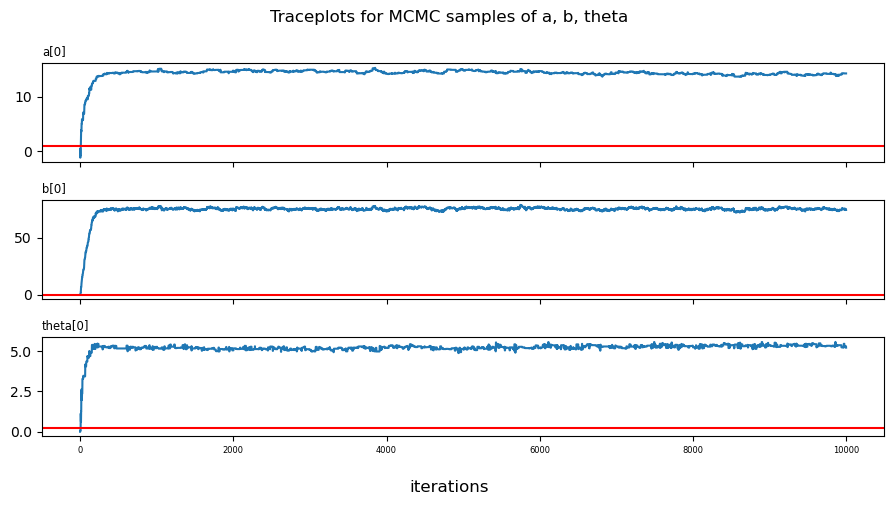

In [39]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(9,5), sharex=True)
fig.suptitle('Traceplots for MCMC samples of a, b, theta')

t = range(10000)

ax1.plot(t, samples_[0][:,0])
ax1.axhline(true_a[0], color="red")
plt.tick_params('x', labelsize=6)
ax1.set_title("a[0]", fontsize='small', loc='left')

ax2.plot(t, samples_[1][:,0])
ax2.axhline(true_b[0], color="red")
ax2.set_title("b[0]", fontsize='small', loc='left')

plt.plot(t, samples_[2][:,0])
ax3.axhline(true_theta[0], color="red")
ax3.set_title("theta[0]", fontsize='small', loc='left')

fig.supxlabel('iterations')
fig.tight_layout()
plt.show()

## Implementation: Adaptive Metropolis-within-Gibbs

In [3]:
def ada_metropolis(prev_sample, sigmasq, scale, s, full_cond, *full_cond_args, rho=0.8, tau=0.3):

    prop = prev_sample + (torch.exp(scale)*torch.distributions.Normal(torch.tensor([0.0]), sigmasq).sample())
    
    # Ensure that sampled values are within [0,1]
    if (prop > 1) or (prop < 0):
        A = 0
    else:
        logr = full_cond(prop, *full_cond_args) - full_cond(prev_sample, *full_cond_args)    
        A = torch.min(torch.tensor([1.0]), torch.exp(logr)) 
    
    #logr = full_cond(prop, *full_cond_args) - full_cond(prev_sample, *full_cond_args)    
    #A = torch.min(torch.tensor([1.0]), torch.exp(logr)) 
    U = (torch.distributions.Uniform(torch.tensor([0.0]), torch.tensor([1.0]))).sample()

    update = None
    
    if U <= A:
        update = prop
    else:
        update = prev_sample

    scale += (1/s**rho)*(A-tau)
    # TODO: calculate and return average acceptance probability?
    return update, scale

def gibbs(init_a, init_b, init_theta, y, sigmasq_a, sigmasq_b, sigmasq_t, niter=10000, adapt=False):
    """Function to perform Gibbs sampling, using Metropolis-within-Gibbs for the intractable full conditional distributions.

    Parameters
    ----------
    init_a : torch.Tensor
        The initial state of variable a
    init_b : torch.Tensor
        The initial state of variable b
    init_theta : torch.Tensor
        The initial state of variable theta
    y : torch.Tensor
        The data
    sigmasq_a : torch.Tensor
        The prior for the variance of variable a
    sigmasq_b : torch.Tensor
        The prior for the variance of variable b
    sigmasq_t : torch.Tensor
        The prior for the variance of variable theta
    niter : int
        The number of samples to collect

    Returns
    -------
    A : torch.Tensor
        The samples for each element of variable a
    B : torch.Tensor
        The samples for each element of variable b
    THETA : torch.Tensor
        The samples for each element of variable theta
    """
    
    assert init_a.shape == init_b.shape
    assert init_theta.shape[0] == y.shape[0]
    
    I = len(init_a)
    P = len(init_theta)
    
    # samples
    A = torch.empty(size=(niter, I))
    B = torch.empty(size=(niter, I))
    THETA = torch.empty(size=(niter, P))
    
    A[0] = init_a
    B[0] = init_b
    THETA[0] = init_theta

    if adapt:
        scale_a, scale_b, scale_t = torch.Tensor([-2.0]), torch.Tensor([-2.0]), torch.Tensor([-2.0])
        print(f"Starting Gibbs sampler with adaptation... \n--------------------------------------------\n")
    else:
        print(f"Starting Gibbs sampler... \n--------------------------------------------\n")
        
    for s in trange(niter):
        
        for i in range(I):

            if not adapt:
                A[s][i] = metropolis(A[s-1][i], sigmasq_a, loga_conditional, B[s-1][i], THETA[s-1], y[:,i], sigmasq_a)
                B[s][i] = metropolis(B[s-1][i], sigmasq_b, logb_conditional, A[s][i], THETA[s-1], y[:,i], sigmasq_b)
            else:
                k = s+1
                A[s][i], scale_a = ada_metropolis(A[s-1][i], sigmasq_a, scale_a, k, loga_conditional, B[s-1][i], THETA[s-1], y[:,i], sigmasq_a)
                B[s][i], scale_b = ada_metropolis(B[s-1][i], sigmasq_b, scale_b, k, logb_conditional, A[s][i], THETA[s-1], y[:,i], sigmasq_b)
            
        for p in range(P):
            if not adapt:
                THETA[s][p] = metropolis(THETA[s-1][p], sigmasq_t, logtheta_conditional, A[s], B[s], y[p,:], sigmasq_t)
            else:
                k = s+1
                THETA[s][p], scale_t = ada_metropolis(THETA[s-1][p], sigmasq_t, scale_t, k, logtheta_conditional, A[s], B[s], y[p,:], sigmasq_t)
    
    print("Done sampling.")
    return A, B, THETA

In [5]:
samples_ada = gibbs(init_a, init_b, init_t, Y, sigmasq_a, sigmasq_b, sigmasq_t, niter=10000, adapt=True)

Starting Gibbs sampler with adaptation... 
--------------------------------------------



100%|██████████| 10000/10000 [14:46<00:00, 11.28it/s]

Done sampling.


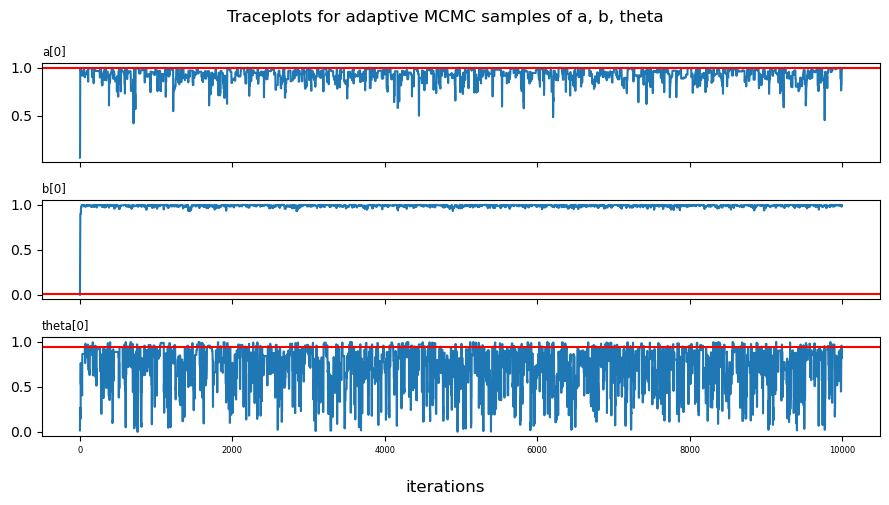

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(9,5), sharex=True)
fig.suptitle('Traceplots for adaptive MCMC samples of a, b, theta')

t = range(10000)

ax1.plot(t, samples_ada[0][:,0])
ax1.axhline(true_a[0], color="red")
plt.tick_params('x', labelsize=6)
ax1.set_title("a[0]", fontsize='small', loc='left')

ax2.plot(t, samples_ada[1][:,0])
ax2.axhline(true_b[0], color="red")
ax2.set_title("b[0]", fontsize='small', loc='left')

plt.plot(t, samples_ada[2][:,0])
ax3.axhline(true_theta[0], color="red")
ax3.set_title("theta[0]", fontsize='small', loc='left')

fig.supxlabel('iterations')
fig.tight_layout()
plt.show()